# 6.Método Cadena Markov-Monte Carlo (MCMC)

In [2]:
using LinearAlgebra
using BenchmarkTools
using SparseArrays
using Random
using Base.Threads: @threads,@spawn
using Plots
using PyCall
using DataFrames

## Implementación de la función que construye el sistema de ecuaciones de prueba $Ax = b$

In [3]:
function matriz_dispersa(n)
    e = ones(n)
    n2 =Int(n/2)
    diags = [-1,0,1]
    A = Matrix(spdiagm(-1 => -ones(n-1)
        ,0 => 3*ones(n),1 => -ones(n-1)))
    c = spdiagm(0 => ones(n)/2)
    ab = [x for x=1:n]
    ba = [(n+1)-x for x=1:n]
    c = Matrix(permute(c, ba, ab))

    A = A + c
    A[n2+1,n2] = -1
    A[n2,n2+1] = -1
    
    b = zeros(n,1)
    b[1] = 2.5
    b[n] = 2.5
    b[2:n-1] .= [1.5]
    b[n2:n2+1] .= [1]
    return A,b
end

matriz_dispersa (generic function with 1 method)

### Evaluación de parámetros

In [4]:
function preparametros(A,b,ϵ,δ)
    M = diagm(0 => diag(A))
    N = M-A
    T = inv(M) * N
    f = inv(M) * b
    nT, mT = size(T);
    print(nT, mT )

    S = fill(0, nT)
    P = fill(0., nT, mT)
    Pa = P
    [S[i] += 1 for i in 1:nT, j in 1:mT if T[i,j] != 0]
    [P[i,j]= 1/S[i] for i in 1:nT, j in 1:mT if T[i,j] != 0 ]
    Pa = [accumulate(+, P[i, 1:mT]) for i in 1:nT]
    Pi = [1/nT for i in 1:nT];
    Nc = floor((0.6745/δ)^2*((norm(f)^2)/(1-norm(T))^2)) + 1
    return Nc, mT, f, Pa, T, P
end

preparametros (generic function with 1 method)

### Matriz de probabilidad acumulada pre-build con envío de parámetros, type-anotations 

In [5]:
function mcmc_acc_par_ta(ϵ, Nc, mT, f, Pa, T, P)
    Xs = fill(0., mT)
        
    for i in 1:mT
        W_0 = 1.0
        for s in 1:Nc
            W = W_0; point = i; X = W_0 * f[i]::Float64
            while abs(W) >= ϵ
                nextpoint  = 1::Int64
                u = rand()
                while u >= Pa[point][nextpoint]::Float64
                    nextpoint = nextpoint + 1::Int64
                end
                    W_new = W *(T[point, nextpoint]/P[point, nextpoint])::Float64
                    X = X + W_new * f[nextpoint]::Float64
                point = nextpoint::Int64
                W = W_new::Float64
            end
        Xs[i] += X::Float64
        end
    end
        
    Xs = Xs/Nc::Float64
end

mcmc_acc_par_ta (generic function with 1 method)

### Matriz de probabilidad acumulada pre-build con envío de parámetros, type-anotations y threads

In [6]:
function mcmc_acc_par_ta_thread(ϵ, Nc, mT, f, Pa, T, P)
    Xs = fill(0., mT)
        
    for i in 1:mT
        W_0 = 1.0
        Threads.@threads for s in 1:Nc
            W = W_0; point = i; X = W_0 * f[i]::Float64
            while abs(W) >= ϵ
                nextpoint  = 1::Int64
                u = rand()
                while u >= Pa[point][nextpoint]::Float64
                    nextpoint = nextpoint + 1::Int64
                end
                    W_new = W *(T[point, nextpoint]/P[point, nextpoint])::Float64
                    X = X + W_new * f[nextpoint]::Float64
                point = nextpoint::Int64
                W = W_new::Float64
            end
        Xs[i] += X::Float64
        end
    end
        
    Xs = Xs/Nc::Float64
end

mcmc_acc_par_ta_thread (generic function with 1 method)

In [ ]:
Threads.nthreads()

In [ ]:
n = [6, 10, 30, 50, 100]
A,b = matriz_dispersa(n[1])
ϵ = 0.1
δ = 0.1 
(Nc, mT, f, Pa, T, P) = preparametros(A,b,ϵ,δ)

In [ ]:
@benchmark mcmc_acc_par_ta_thread($ϵ, $Nc, $mT, $f, $Pa, $T, $P)

In [ ]:
X  = @btime mcmc_acc_par_ta_thread($ϵ, $Nc, $mT, $f, $Pa, $T, $P)

In [ ]:
norm(b-A*X)

In [20]:
yMMCM_th = []
yMMCM = []
n = [6, 10, 30, 50, 100]
ϵ = 0.1
δ = 0.1 
Nc= mT= f= Pa= T= P=0
for i = n
    A,b = matriz_dispersa(i)
    ϵ = 0.1
    δ = 0.1 
    (Nc, mT, f, Pa, T, P) = preparametros(A,b,ϵ,δ)
    jTh = @benchmark mcmc_acc_par_ta_thread(ϵ, Nc, mT, f, Pa, T, P) seconds=1
    jJ = @benchmark mcmc_acc_par_ta(ϵ, Nc, mT, f, Pa, T, P) seconds=1
    push!(yMMCM_th, jTh)
    push!(yMMCM, jJ)

end

66101030305050100100

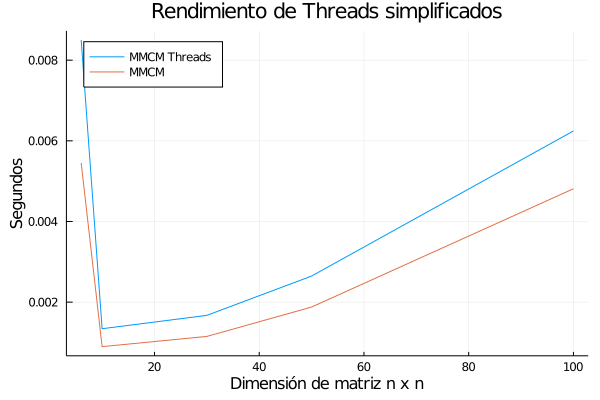

In [21]:
plot(title="Rendimiento de Threads simplificados", legend=:topleft, xaxis="Dimensión de matriz n x n", yaxis="Segundos")
plot!(n, [minimum(yMMCM_th[i]).time/10^9  for i=1:size(n)[1]], label="MMCM Threads")
plot!(n, [minimum(yMMCM[i]).time/10^9  for i=1:size(n)[1]], label="MMCM ")